In [1]:
from collections import defaultdict
from pathlib import Path
import re

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tqdm

In [2]:
re_int = re.compile(r'[0-9]+')

def int_from_dir_path(dir_path):
    name = dir_path.name
    return int(re_int.search(name)[0])

In [3]:
BR_RESULTS_ROOT = Path('~/Documents/repos/coding/birdsong/tweetynet/results/BirdsongRecognition').expanduser().resolve()

In [4]:
BIRDS_ROOTS = sorted(BR_RESULTS_ROOT.glob('Bird*'))

In [5]:
dfs = []

for bird_root in BIRDS_ROOTS:
    if bird_root.name == 'Bird10':
        continue  # didn't run experiment, not enough data for test set of correct duration
    else:
        bird_num = int_from_dir_path(bird_root)
        results_roots = sorted(bird_root.glob('results_*'))
        most_recent_results = results_roots[-1]
        df = pd.read_csv(most_recent_results.joinpath('learning_curve.csv'))
        df['avg_error'] = 1 - df['avg_acc']
        df['bird'] = bird_num
        dfs.append(df)

curve_df = pd.concat(dfs)
# make 'bird' the first column
columns = ['bird', 'train_set_dur', 'replicate_num', 'model_name', 'avg_acc', 'avg_levenshtein', 'avg_loss', 'avg_segment_error_rate', 'avg_error']
curve_df = curve_df[columns]
curve_df['bird'] = curve_df['bird'].astype('category')

In [6]:
curve_df.head()

,bird,train_set_dur,replicate_num,model_name,avg_acc,avg_levenshtein,avg_loss,avg_segment_error_rate,avg_error
0,0,120.0,1,TweetyNet,0.964375,139,0.116330,0.059332,0.035625
1,0,120.0,10,TweetyNet,0.973549,97,0.083475,0.042982,0.026451
2,0,120.0,2,TweetyNet,0.968502,118,0.105680,0.051192,0.031498
3,0,120.0,3,TweetyNet,0.965855,136,0.108927,0.057526,0.034145
4,0,120.0,4,TweetyNet,0.967369,124,0.103485,0.053421,0.032631


In [7]:
curve_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 600 entries, 0 to 59
Data columns (total 9 columns):
bird                      600 non-null category
train_set_dur             600 non-null float64
replicate_num             600 non-null int64
model_name                600 non-null object
avg_acc                   600 non-null float64
avg_levenshtein           600 non-null int64
avg_loss                  600 non-null float64
avg_segment_error_rate    600 non-null float64
avg_error                 600 non-null float64
dtypes: category(1), float64(5), int64(2), object(1)
memory usage: 43.2+ KB


In [8]:
records = defaultdict(list)

for train_set_dur in curve_df['train_set_dur'].unique():
    for bird in curve_df['bird'].unique():
        records['bird'].append(bird)
        records['train_set_dur'].append(train_set_dur)
        bird_dur_df = curve_df[(curve_df['bird'] == bird) & (curve_df['train_set_dur'] == train_set_dur)]
        describe_df = bird_dur_df.describe().T
        for metric in ['avg_error', 'avg_levenshtein', 'avg_segment_error_rate']:
            for stat_name in ['mean', 'std', 'min', '25%', '50%', '75%', 'max', 'count']:
                metric_name = metric.replace('avg_', '')  # remove "avg_" prefix -- going to append a suffix
                records[f'{metric_name}_{stat_name}'].append(describe_df.loc[metric, stat_name])
            

summary_df = pd.DataFrame.from_records(records)
COLUMNS = ['bird', 'train_set_dur', 
           'error_25%', 'error_50%', 'error_75%', 'error_count',
           'error_max', 'error_mean', 'error_min', 'error_std', 'levenshtein_25%',
           'levenshtein_50%', 'levenshtein_75%', 'levenshtein_count',
           'levenshtein_max', 'levenshtein_mean', 'levenshtein_min',
           'levenshtein_std', 'segment_error_rate_25%', 'segment_error_rate_50%',
           'segment_error_rate_75%', 'segment_error_rate_count',
           'segment_error_rate_max', 'segment_error_rate_mean',
           'segment_error_rate_min', 'segment_error_rate_std']
summary_df = summary_df[COLUMNS]
summary_df['bird'] = summary_df['bird'].astype('category')
summary_df = summary_df.sort_values(by=['bird', 'train_set_dur'])

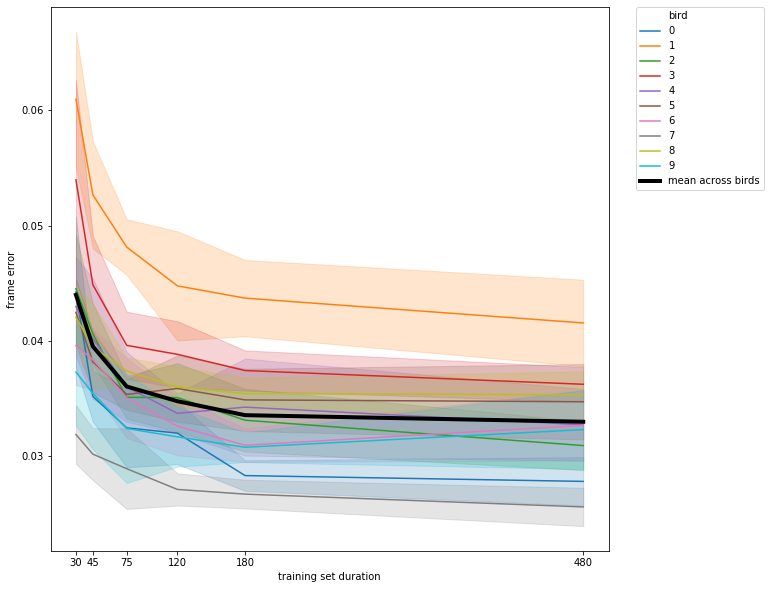

In [9]:
fig, ax = plt.subplots(figsize=(10,10))

g = sns.lineplot(x='train_set_dur', y='avg_error', hue='bird', data=curve_df, ci='sd')
g = sns.lineplot(x='train_set_dur', y='avg_error', linestyle='dashed', color='k', linewidth=4, 
                 data=curve_df, ci=None, label='mean across birds')
g.set_xlabel('training set duration')
g.set_ylabel('frame error')
g.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
g.set_xticks(curve_df['train_set_dur'].unique());

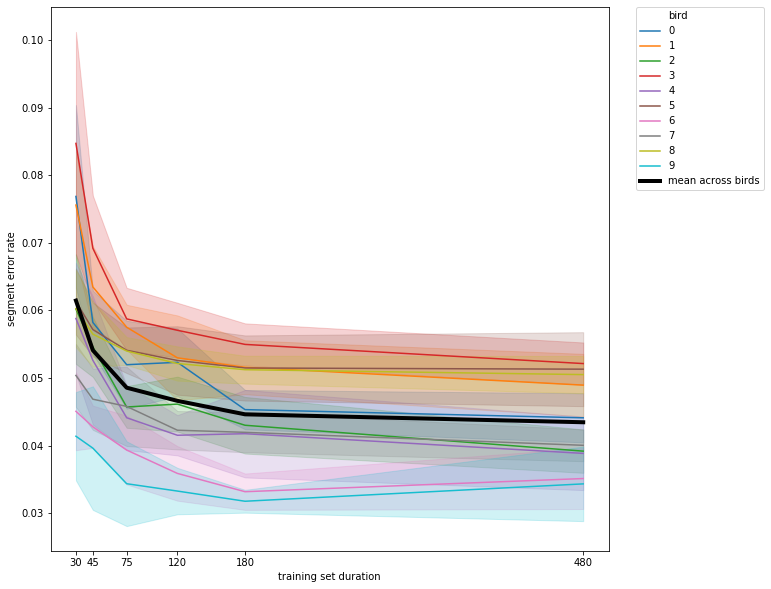

In [10]:
fig, ax = plt.subplots(figsize=(10,10))

g = sns.lineplot(x='train_set_dur', y='avg_segment_error_rate', hue='bird', data=curve_df, ci='sd')
g = sns.lineplot(x='train_set_dur', y='avg_segment_error_rate', linestyle='dashed', color='k', linewidth=4, 
                 data=curve_df, ci=None, label='mean across birds')
g.set_xlabel('training set duration')
g.set_ylabel('segment error rate')
g.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
g.set_xticks(curve_df['train_set_dur'].unique());